## Final Notebook with heatmap test

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
bs = 32

In [4]:
from pathlib import Path

In [5]:
path = Path('./data')
path

PosixPath('data')

### Data
Inspect Augmentations, using ImageList object

In [6]:
path_train = path/'train'
path_test = path/'test'
path_train

PosixPath('data/train')

In [7]:
tfms = get_transforms(flip_vert=True, max_warp=0.1)

In [8]:
tfms = get_transforms(flip_vert=True, max_rotate=40, max_zoom=1.3, max_lighting=0.3, max_warp=0,
                      p_affine=1., p_lighting=1.)

get_transforms(
    
    do_flip: bool = True, 
    flip_vert: bool = False,  
    max_rotate: float = 10.0,
    max_zoom: float = 1.1,
    max_lighting: float = 0.2,
    max_warp: float = 0.2,
    p_affine: float = 0.75,
    p_lighting: float = 0.75,

In [9]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [10]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_folder()
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [11]:
data = get_data(224, bs)

### Plot for Inspecting Actual Augment Effects

In [12]:
def _plot(i, j, ax):
    x, y = data.train_ds[3]
    x.show(ax, y=y)

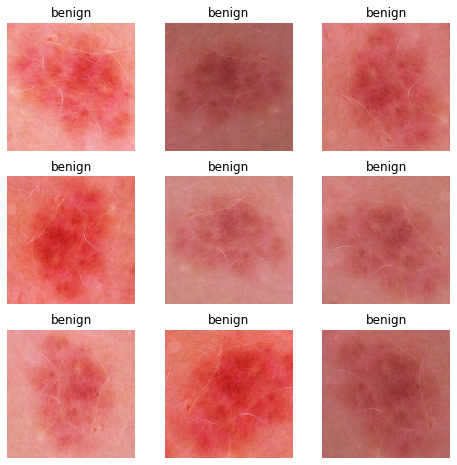

In [13]:
plot_multi(_plot, 3, 3, figsize=(8, 8))

## Model Training: Resnet 50

In [14]:
torch.cuda.empty_cache()

In [15]:
gc.collect()
learn = cnn_learner(data, models.resnet50, metrics=error_rate, bn_final=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


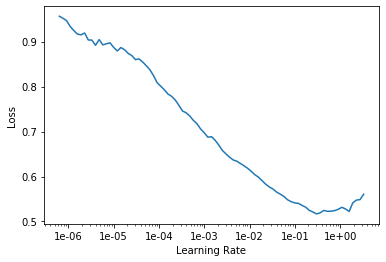

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(4, slice(1e-2/2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.419049,0.362855,0.169954,00:22
1,0.366521,0.337543,0.177542,00:26
2,0.334370,0.328505,0.145675,00:28
3,0.303351,0.317392,0.141123,00:26


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


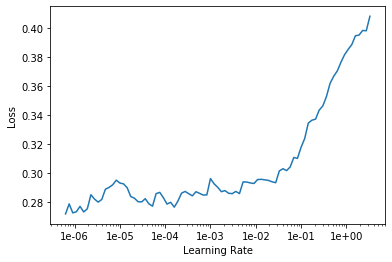

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6, 1e-4), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.285155,0.311729,0.136571,00:29
1,0.271780,0.302815,0.133536,00:31
2,0.273782,0.302712,0.133536,00:33


### Upsize Data

In [20]:
data = get_data(224, bs)
learn.data = data
learn.freeze()

In [21]:
torch.cuda.empty_cache()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


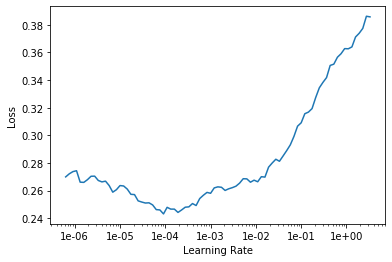

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(3, max_lr=1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.264188,0.292664,0.122914,00:28
1,0.256485,0.295652,0.116844,00:27
2,0.256207,0.294346,0.119879,00:21


In [24]:
learn.unfreeze()

In [25]:
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.246339,0.283246,0.113809,00:27
1,0.237989,0.288735,0.113809,00:28


In [26]:
#learn.save('final-rn50-90')

## HeatMap
At this point this is just a copy paste of the lesson 6 code. Still trying to find what we actually need to pull out.

In [28]:
from fastai.callbacks.hooks import *

In [29]:
data = get_data(224, 16)

In [31]:
m = learn.model.eval(); #m[0] is the front of the model

In [33]:
def hooked_backward(cat=y):
    """
    Have no idea what cat=y does.  Applys the pytorch hooks to gather
    activations from the conv network that are normally thrown away.
    """
    with hook_output(m[0]) as hook_a:
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0, int(cat)].backward()
    return hook_a, hook_g

Category malignant

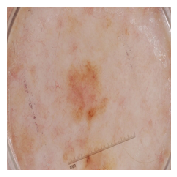

In [60]:
idx=3
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [36]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [37]:
hook_a, hook_g = hooked_backward()

In [38]:
acts = hook_a.stored[0].cpu()
acts.shape

torch.Size([2048, 7, 7])

In [39]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([7, 7])

In [42]:
def show_heatmap(hm):
    _, ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0, 224, 224, 0),
             interpolation='bilinear', cmap='magma');

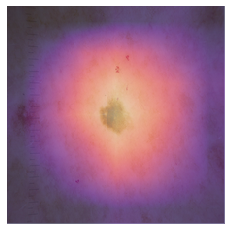

In [43]:
show_heatmap(avg_acts)

## GradCam stuff?

In [44]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1)
grad.shape, grad_chan.shape

(torch.Size([2048, 7, 7]), torch.Size([2048, 7]))

In [45]:
mult = (acts*grad_chan[...,None,None]).mean(0)

RuntimeError: The size of tensor a (2048) must match the size of tensor b (7) at non-singleton dimension 1

In [46]:
show_heatmap(mult)

NameError: name 'mult' is not defined

In [ ]:
fn = path/'' # Replace with your own image

In [47]:
x = open_image(fn); x

NameError: name 'fn' is not defined

In [48]:
hook_a, hook_g = hooked_backward()

In [49]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

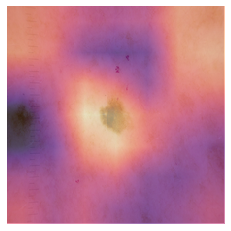

In [50]:
show_heatmap(mult)

In [51]:
data.classes[0]

'benign'

In [52]:
hook_a, hook_g = hooked_backward(0)

In [54]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[..., None, None]).mean(0)

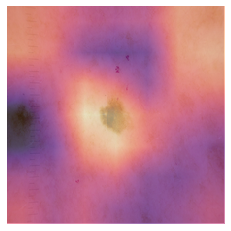

In [55]:
show_heatmap(mult)